# 1. Introduction
# ICU survival modeling, Part 2: Cox and predictive models

**Approach**
- Teach and compare three models using the same preprocessing and the same train, validation, and test sets  
  - Cox proportional hazards for time-to-event  
  - Decision Tree classifier at fixed horizons  
  - Random Forest classifier at fixed horizons

**Learning goals**
- Build fair, fixed-horizon predictions at 7, 30, and 60 days from ICU admission  
- Understand discrimination vs calibration and why both matter clinically  
- See interpretability trade-offs across Cox, a single tree, and an ensemble forest  
- Practice leakage-free preprocessing with scikit-learn Pipelines

**Data**
- PhysioNet CinC Challenge 2012 ICU cohort, set A, 4000 stays, first 48 h features plus outcomes  
- Outcomes available  
  - Length of stay in days  
  - Survival in days up to 2 years  
  - In-hospital death indicator

**Fair comparison plan**
1) One reproducible split into train, validation, and test used by all models  
2) Identical preprocessing via a single scikit-learn ColumnTransformer  
3) Fixed-horizon evaluation at 7, 30, 60 days on the same evaluable patients per horizon  
4) Report AUROC, area under precision-recall, Brier score, and compact calibration by bins

**Clinical reading of metrics**
- Discrimination ranks who is higher risk  
- Calibration asks if predicted risk matches observed risk at a threshold relevant for action

References  
- Official challenge description and variable definitions, including Survival and In-hospital death  


# 2. Setup


In [36]:
## 2) Code cell — Setup and reproducibility

# 2. Setup and reproducibility

# Standard library
from pathlib import Path
import warnings
import math
import os
import sys
import random

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Modeling
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

# Lifelines
from lifelines import CoxPHFitter

# Our helpers
sys.path.append("/mnt/data")
import utils  # uses build_preprocessor, detect_feature_types, to_dataframe, labeling and calibration helpers

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Pandas and plotting defaults
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 120)
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (7, 4)

# Paths
DATA_PATH = Path("/mnt/data/PhysionetChallenge2012-set-a.csv.gz")

print("Versions")
print("numpy", np.__version__)
print("pandas", pd.__version__)
import sklearn
print("scikit-learn", sklearn.__version__)
import lifelines
print("lifelines", lifelines.__version__)


Versions
numpy 2.3.3
pandas 2.3.3
scikit-learn 1.7.2
lifelines 0.30.0


# 3. Load data and define outcomes

In [5]:
# 3. Load data and define variables  [in-hospital death endpoint]

# --- 1. Load Data ---
PATH = "PhysionetChallenge2012-set-a.csv.gz"

# Simple check to ensure the data file exists before trying to load it
if not os.path.exists(PATH):
    raise FileNotFoundError(
        f"Error: The data file was not found at '{PATH}'. "
        "Please ensure the dataset is in the correct directory."
    )

raw = pd.read_csv(PATH, compression="gzip")
    
# Basic sanity checks
required_cols = {"Length_of_stay", "Survival", "In-hospital_death"}
missing = required_cols.difference(raw.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Endpoint locked to in-hospital death
# Duration is time from ICU admission to discharge or in-hospital death
# Event is 1 if died in hospital, 0 if discharged alive
def make_outcomes_in_hospital(df: pd.DataFrame) -> pd.DataFrame:
    y = pd.DataFrame(index=df.index)
    los = pd.to_numeric(df["Length_of_stay"], errors="coerce").astype(float)
    los = np.clip(los, 0.0, None)  # clip negatives to 0 days
    event = pd.to_numeric(df["In-hospital_death"], errors="coerce").fillna(0).astype(int)
    y["duration_days"] = los
    y["event_death"] = event
    return y

y = make_outcomes_in_hospital(raw)

# Feature frame: drop outcome columns and obvious identifiers to avoid leakage
drop_cols = ["In-hospital_death", "Survival", "Length_of_stay", "recordid"]
X = raw.drop(columns=[c for c in drop_cols if c in raw.columns], errors="ignore").copy()

print("Outcome head")
display(y.head(3).style)
print("Features shape", X.shape)

# Quick outcome summary
event_rate = float(y["event_death"].mean())
duration = y["duration_days"].to_numpy()
iqr = float(np.percentile(duration, 75) - np.percentile(duration, 25))
print(f"Event rate: {event_rate:.3f}")
print(f"Follow-up days: median {float(np.median(duration)):.1f}  IQR {iqr:.1f}")


Outcome head


,duration_days,event_death
0,5.000000,0
1,8.000000,0
2,19.000000,0


Features shape (4000, 116)
Event rate: 0.139
Follow-up days: median 10.0  IQR 11.0


## 3.1 Preprocessing and leakage control
- Detect numeric vs categorical features programmatically  
- Numeric pipeline  
  - SimpleImputer with median  
- Categorical pipeline  
  - SimpleImputer with most frequent  
  - OneHotEncoder with ignore for unseen categories  
- Build one ColumnTransformer used by all models inside scikit-learn Pipelines  
- We exclude outcome variables and identifiers from the feature matrix to prevent target leakage


In [ ]:
# 3.1 Build shared preprocessor

num_cols, cat_cols = utils.detect_feature_types(X)
print("Numeric", len(num_cols), "Categorical", len(cat_cols))

preprocessor: ColumnTransformer = utils.build_preprocessor(num_cols, cat_cols)

# Fit preprocessor only on the training partition later; here we can preview on the full data safely without leaking,
# but we will re-fit strictly on train after we split
preprocessor.fit(X)
Xt_preview = utils.to_dataframe(preprocessor, X.head(200))
display(Xt_preview.head(3).style)
print("Transformed preview shape", Xt_preview.shape)


Numeric 116 Categorical 0


,num__SAPS-I,num__SOFA,num__Age,num__Gender,num__Height,num__Weight,num__CCU,num__CSRU,num__SICU,num__DiasABP_first,num__GCS_first,num__Glucose_first,num__HR_first,num__MAP_first,num__NIDiasABP_first,num__NIMAP_first,num__NISysABP_first,num__RespRate_first,num__SaO2_first,num__Temp_first,num__DiasABP_last,num__GCS_last,num__Glucose_last,num__HR_last,num__MAP_last,num__NIDiasABP_last,num__NIMAP_last,num__NISysABP_last,num__RespRate_last,num__SaO2_last,num__Temp_last,num__DiasABP_lowest,num__GCS_lowest,num__Glucose_lowest,num__HR_lowest,num__MAP_lowest,num__NIDiasABP_lowest,num__NIMAP_lowest,num__NISysABP_lowest,num__RespRate_lowest,num__SaO2_lowest,num__Temp_lowest,num__DiasABP_highest,num__GCS_highest,num__Glucose_highest,num__HR_highest,num__MAP_highest,num__NIDiasABP_highest,num__NIMAP_highest,num__NISysABP_highest,num__RespRate_highest,num__SaO2_highest,num__Temp_highest,num__DiasABP_median,num__GCS_median,num__Glucose_median,num__HR_median,num__MAP_median,num__NIDiasABP_median,num__NIMAP_median,num__NISysABP_median,num__RespRate_median,num__SaO2_median,num__Temp_median,num__ALP_first,num__ALT_first,num__AST_first,num__Albumin_first,num__BUN_first,num__Bilirubin_first,num__Cholesterol_first,num__Creatinine_first,num__FiO2_first,num__HCO3_first,num__HCT_first,num__K_first,num__Lactate_first,num__Mg_first,num__Na_first,num__PaCO2_first,num__PaO2_first,num__Platelets_first,num__SysABP_first,num__TroponinI_first,num__TroponinT_first,num__WBC_first,num__Weight_first,num__pH_first,num__ALP_last,num__ALT_last,num__AST_last,num__Albumin_last,num__BUN_last,num__Bilirubin_last,num__Cholesterol_last,num__Creatinine_last,num__FiO2_last,num__HCO3_last,num__HCT_last,num__K_last,num__Lactate_last,num__Mg_last,num__Na_last,num__PaCO2_last,num__PaO2_last,num__Platelets_last,num__SysABP_last,num__TroponinI_last,num__TroponinT_last,num__WBC_last,num__Weight_last,num__pH_last,num__MechVentStartTime,num__MechVentDuration,num__MechVentLast8Hour,num__UrineOutputSum
0,6.000000,1.000000,54.000000,0.000000,170.200000,78.700000,0.000000,0.000000,1.000000,61.000000,15.000000,205.000000,73.000000,82.000000,65.000000,92.330000,147.000000,19.000000,98.000000,35.100000,60.000000,15.000000,115.000000,86.000000,80.000000,55.000000,79.330000,128.000000,23.000000,97.000000,37.800000,44.000000,14.000000,115.000000,58.000000,58.000000,39.000000,58.670000,96.000000,12.000000,96.000000,35.100000,81.000000,15.000000,205.000000,86.000000,109.000000,67.000000,92.330000,157.000000,24.000000,98.000000,38.200000,58.000000,15.000000,160.000000,73.000000,78.000000,49.000000,70.000000,110.000000,18.000000,97.500000,37.700000,79.000000,31.000000,46.000000,3.000000,13.000000,0.700000,153.000000,0.800000,1.000000,26.000000,33.700000,4.400000,1.900000,1.500000,137.000000,40.000000,168.000000,221.000000,121.000000,2.200000,0.130000,11.200000,81.150000,7.380000,78.000000,31.000000,44.000000,3.000000,8.000000,0.700000,152.000000,0.700000,0.500000,28.000000,30.300000,4.000000,1.600000,1.900000,136.000000,39.000000,106.000000,185.000000,121.000000,2.000000,0.130000,9.400000,82.200000,7.400000,122.000000,2320.000000,1.000000,13.000000
1,16.000000,8.000000,76.000000,1.000000,175.300000,76.000000,0.000000,1.000000,0.000000,67.000000,3.000000,105.000000,88.000000,79.000000,38.000000,49.330000,72.000000,19.000000,99.000000,35.200000,51.000000,15.000000,146.000000,65.000000,69.000000,49.000000,68.330000,107.000000,19.000000,97.000000,37.100000,32.000000,3.000000,105.000000,65.000000,43.000000,38.000000,49.330000,72.000000,12.000000,93.000000,34.500000,81.000000,15.000000,146.000000,90.000000,100.000000,67.000000,88.330000,131.000000,28.000000,99.000000,37.900000,59.000000,15.000000,125.500000,80.000000,79.000000,59.000000,78.165000,115.000000,19.000000,97.000000,37.450000,79.000000,31.000000,46.000000,3.000000,16.000000,0.700000,153.000000,0.800000,1.000000,21.000000,24.700000,4.300000,1.900000,3.100000,139.000000,34.000000,344.000000,164.000000,105.000000,2.200000,0.130000,7.400000,80.

Transformed preview shape (200, 116)


## 3.2. Splitting
- Stratified split by the binary event to keep class balance stable  
- Proportions  
  - Train 60 percent  
  - Validation 20 percent  
  - Test 20 percent  
- The same indices are reused for Cox, Decision Tree, and Random Forest  
- We will always report metrics on the held-out test set and use validation only for light hyperparameter selection


In [7]:
# 3.2 Create stratified train, validation, and test splits re-used across all models

def make_splits(X: pd.DataFrame, y: pd.Series, seed: int = 42):
    # First split off test 20 percent
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=seed)
    train_val_idx, test_idx = next(sss1.split(X, y))
    X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
    y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]

    # Split train vs validation 75:25 within the remaining 80 percent to yield 60:20:20 overall
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=seed)
    train_idx, val_idx = next(sss2.split(X_train_val, y_train_val))

    idx_train = X_train_val.index[train_idx]
    idx_val = X_train_val.index[val_idx]
    idx_test = X_test.index

    return idx_train, idx_val, idx_test

idx_train, idx_val, idx_test = make_splits(X, y["event_death"], seed=SEED)

print("Split sizes",
      "train", len(idx_train),
      "val", len(idx_val),
      "test", len(idx_test))

# Materialize split datasets
X_train, X_val, X_test = X.loc[idx_train], X.loc[idx_val], X.loc[idx_test]
y_train, y_val, y_test = y.loc[idx_train], y.loc[idx_val], y.loc[idx_test]

# Fit the shared preprocessor on train only
preprocessor = utils.build_preprocessor(*utils.detect_feature_types(X_train))
preprocessor.fit(X_train)

# Transformed DataFrames for convenience in Cox and for inspection
Xt_train = utils.to_dataframe(preprocessor, X_train)
Xt_val   = utils.to_dataframe(preprocessor, X_val)
Xt_test  = utils.to_dataframe(preprocessor, X_test)

print("Transformed shapes",
      Xt_train.shape, Xt_val.shape, Xt_test.shape)

# Quick leakage sanity check: confirm no outcome columns survived
assert not any(c.lower().startswith("in-hospital_death") for c in Xt_train.columns)
assert not any(c.lower().startswith("survival") for c in Xt_train.columns)
assert not any(c.lower().startswith("length_of_stay") for c in Xt_train.columns)


Split sizes train 2400 val 800 test 800
Transformed shapes (2400, 116) (800, 116) (800, 116)


# 4. Cox recap and fixed-horizon scoring

What we keep: 
- Same endpoint in-hospital death with duration_days in days and event_death as the event  
- Same preprocessing via the shared ColumnTransformer fit on train and applied to validation and test  
- Same splits

What we add now  
- Fit a single multivariable Cox model on the preprocessed training set  
- Compute fixed-horizon risks at 7, 30, and 60 days on validation and test  
- Evaluate discrimination, calibration, and overall accuracy on the identical evaluable cohorts per horizon  
- Store predictions, evaluability masks, and a tidy metrics table for later comparisons

In [16]:
# 7.1 Cox recap and fixed-horizon scoring

# Horizons in days
HORIZONS = [7, 30, 60]

# 1) Prepare modeling frames for lifelines using preprocessed matrices from earlier steps
df_train = Xt_train.copy()
df_train["duration_days"] = y_train["duration_days"].values
df_train["event_death"]   = y_train["event_death"].values

df_val = Xt_val.copy()
df_val["duration_days"] = y_val["duration_days"].values
df_val["event_death"]   = y_val["event_death"].values

df_test = Xt_test.copy()
df_test["duration_days"] = y_test["duration_days"].values
df_test["event_death"]   = y_test["event_death"].values

# 2) Fit Cox on train only
cph = CoxPHFitter()
cph.fit(df_train, duration_col="duration_days", event_col="event_death")

# 3) Cox fixed-horizon risks using utils, no renaming
cph_pred_train = utils.predict_fixed_horizon_risk_from_cox(cph, Xt_train, [7, 30, 60])
cph_pred_val   = utils.predict_fixed_horizon_risk_from_cox(cph, Xt_val,   [7, 30, 60])
cph_pred_test  = utils.predict_fixed_horizon_risk_from_cox(cph, Xt_test,  [7, 30, 60])

# 4) Fixed-horizon labels and evaluability masks using utils signature
labels_train, labels_val, labels_test = {}, {}, {}
for h in [7, 30, 60]:
    yb_tr, m_tr = utils.get_fixed_horizon_labels(y_train, horizon_days=h)
    yb_va, m_va = utils.get_fixed_horizon_labels(y_val,   horizon_days=h)
    yb_te, m_te = utils.get_fixed_horizon_labels(y_test,  horizon_days=h)
    labels_train[h] = {"y_true": pd.Series(yb_tr, index=y_train.index).astype(int),
                       "mask":   pd.Series(m_tr,  index=y_train.index).astype(bool)}
    labels_val[h]   = {"y_true": pd.Series(yb_va, index=y_val.index).astype(int),
                       "mask":   pd.Series(m_va, index=y_val.index).astype(bool)}
    labels_test[h]  = {"y_true": pd.Series(yb_te, index=y_test.index).astype(int),
                       "mask":   pd.Series(m_te, index=y_test.index).astype(bool)}

# 5) Metrics per horizon on identical evaluable cohorts
records = []
for set_name, preds, labels in [
    ("train", cph_pred_train, labels_train),
    ("val",   cph_pred_val,   labels_val),
    ("test",  cph_pred_test,  labels_test),
]:
    for h in [7, 30, 60]:
        col = f"Risk_{h}d"              # use utils naming
        m = labels[h]["mask"]
        y = labels[h]["y_true"][m].to_numpy()
        p = preds[col][m].to_numpy()
        if y.size == 0 or len(np.unique(y)) < 2:
            auroc = np.nan; auprc = np.nan; brier = np.nan
        else:
            auroc = roc_auc_score(y, p)
            auprc = average_precision_score(y, p)
            brier = brier_score_loss(y, p)
        records.append({
            "model": "Cox",
            "set": set_name,
            "horizon_days": h,
            "auroc": float(auroc) if np.isfinite(auroc) else np.nan,
            "auprc": float(auprc) if np.isfinite(auprc) else np.nan,
            "brier": float(brier) if np.isfinite(brier) else np.nan,
            "n_evaluable": int(m.sum())
        })

cph_metrics = pd.DataFrame.from_records(records).sort_values(["set", "horizon_days"])
display(cph_metrics.style)

# Optional compact calibration summaries on test using sklearn-style bins
calib_cph_test = {}
for h in [7, 30, 60]:
    m = labels_test[h]["mask"]
    y = labels_test[h]["y_true"][m].to_numpy()
    p = cph_pred_test[f"Risk_{h}d"][m].to_numpy()
    if y.size == 0 or len(np.unique(y)) < 2:
        calib_cph_test[h] = pd.DataFrame({"prob_mean": [], "event_rate": []})
    else:
        frac_pos, prob_mean = calibration_curve(y, p, n_bins=10, strategy="quantile")
        calib_cph_test[h] = pd.DataFrame({"prob_mean": prob_mean, "event_rate": frac_pos})

# Store artifacts unchanged
ARTIFACTS = {
    "cph_model": cph,
    "cph_pred_train": cph_pred_train,
    "cph_pred_val":   cph_pred_val,
    "cph_pred_test":  cph_pred_test,
    "labels_train": labels_train,
    "labels_val":   labels_val,
    "labels_test":  labels_test,
    "cph_metrics":  cph_metrics,
    "calib_cph_test": calib_cph_test,
    "horizons_days": [7, 30, 60],
}


,model,set,horizon_days,auroc,auprc,brier,n_evaluable
6,Cox,test,7,0.794999,0.249614,0.067331,596
7,Cox,test,30,0.682333,0.764004,0.291269,160
8,Cox,test,60,0.694444,0.971101,0.193629,114
0,Cox,train,7,0.856604,0.430239,0.049860,1833
1,Cox,train,30,0.784106,0.857376,0.229372,488
2,Cox,train,60,0.880734,0.989202,0.151444,353
3,Cox,val,7,0.799507,0.237835,0.054764,615
4,Cox,val,30,0.730904,0.766264,0.254967,168
5,Cox,val,60,0.747706,0.956124,0.205476,119


#### **Quick recap on metrics**
* **`auroc`** (Area Under the ROC Curve): This is a measure of **ranking**. It tells us if the model is good at giving higher-risk patients higher scores than lower-risk patients
* **`auprc`** (Area Under the Precision-Recall Curve): This is a measure of **positive prediction value**, which is very useful when the event (death) is rare. It answers: "When the model predicts a patient is high-risk, how often is it correct?"
* **`brier`**: This measures the **accuracy of the probability score itself**. It penalizes models for being overconfident or underconfident. A perfect score is 0. **Lower is better**

**Clinical takeaways**
* **It's a strong baseline**: An AUROC of ~0.80 on the test set for short-term risk is a solid result and provides genuine clinical value. It shows that the model is effective at identifying which patients are at higher risk
* **Actionability**: Before using these risk scores to make decisions (e.g., flagging a patient for a clinical review), we would also need to check its **calibration**

# 5. Decision Tree setup and training
### Decision Tree at fixed horizons

- While the Cox model looks at the *rate* of events over time, a Decision Tree works differently. It learns a series of simple "if-then" rules from the data to predict a binary outcome, like "will this patient die within 7 days?"

**Why this model**
* **High Interpretability**: A small Decision Tree is like a flowchart. We can literally draw it and follow the logic, making it very transparent and easy to explain to clinicians.
* **No Proportional Hazards Assumption**: Unlike the Cox model, it doesn't assume a variable's effect is constant over time. It can learn different rules for different patient subgroups.
* **Captures Interactions**: It can naturally find patterns like "if `SOFA` score is high AND the patient is on a ventilator, then the risk is very high."

**Evaluation**
- Train on the evaluable training cohort for each horizon
- Use light cross-validation on the training set to choose max_depth and min_samples_leaf
- Score on validation and test with the same evaluable cohorts used for Cox
- Store predictions and metrics for side-by-side comparison


In [ ]:
# 5.2 Decision Tree at fixed horizons

# Use the shared horizons and labels from ARTIFACTS
HORIZONS = ARTIFACTS["horizons_days"]
labels_train = ARTIFACTS["labels_train"]
labels_val   = ARTIFACTS["labels_val"]
labels_test  = ARTIFACTS["labels_test"]

# We wrap our already-fitted preprocessor in a FunctionTransformer.
# This prevents the pipeline from trying to re-fit it, which would cause data leakage.
# All models MUST use the exact same preprocessing rules learned only from the original training set.
frozen_pre = FunctionTransformer(lambda X: preprocessor.transform(X))

# Define a simple pipeline and a small grid for hyperparameter tuning.
pipe_tree = Pipeline(steps=[
    ("pre", frozen_pre),
    ("clf", DecisionTreeClassifier(random_state=SEED, class_weight="balanced"))
])

# These are the "knobs" we'll turn to find the best, simplest tree.
param_grid = {
    "clf__max_depth": [3, 4, 5, 6],
    "clf__min_samples_leaf": [25, 50, 100]
}

# Containers for predictions and metrics
dt_pred_train = pd.DataFrame(index=X_train.index)
dt_pred_val   = pd.DataFrame(index=X_val.index)
dt_pred_test  = pd.DataFrame(index=X_test.index)
rows = []

print("Training Decision Tree for each horizon...")
for h in HORIZONS:
    # Get the correct labels and masks for this specific horizon
    m_tr = labels_train[h]["mask"]
    m_va = labels_val[h]["mask"]
    m_te = labels_test[h]["mask"]

    y_tr = labels_train[h]["y_true"][m_tr].to_numpy()
    y_va = labels_val[h]["y_true"][m_va].to_numpy()
    y_te = labels_test[h]["y_true"][m_te].to_numpy()

    # We fit the grid search ONLY on the patients who are "evaluable" for this horizon.
    # This ensures the model learns from the most relevant data.
    grid = GridSearchCV(
        estimator=pipe_tree,
        param_grid=param_grid,
        scoring="roc_auc", # We'll judge the best tree based on its ranking ability
        cv=3,
        n_jobs=-1,
        refit=True,
        verbose=0
    )
    grid.fit(X_train.loc[m_tr], y_tr)

    # Store a compact view of the chosen hyperparameters
    best_params = grid.best_params_
    print(f"Horizon {h}d best params: {best_params}")

    # Predict probabilities for ALL patients using the best model found
    p_tr = grid.predict_proba(X_train)[:, 1]
    p_va = grid.predict_proba(X_val)[:, 1]
    p_te = grid.predict_proba(X_test)[:, 1]

    colname = f"DT_Risk_{h}d"
    dt_pred_train[colname] = p_tr
    dt_pred_val[colname]   = p_va
    dt_pred_test[colname]  = p_te

    # Helper to calculate metrics safely on the evaluable cohorts
    def _safe_metrics(y, p):
        if y.size == 0 or len(np.unique(y)) < 2:
            return np.nan, np.nan, np.nan
        return roc_auc_score(y, p), average_precision_score(y, p), brier_score_loss(y, p)

    au_tr, ap_tr, br_tr = _safe_metrics(y_tr, p_tr[m_tr])
    au_va, ap_va, br_va = _safe_metrics(y_va, p_va[m_va])
    au_te, ap_te, br_te = _safe_metrics(y_te, p_te[m_te])

    rows += [
        {"model": "DecisionTree", "set": "train", "horizon_days": h,
         "auroc": au_tr, "auprc": ap_tr, "brier": br_tr, "n_evaluable": int(m_tr.sum()),
         "best_max_depth": best_params["clf__max_depth"], "best_min_samples_leaf": best_params["clf__min_samples_leaf"]},
        {"model": "DecisionTree", "set": "val",   "horizon_days": h,
         "auroc": au_va, "auprc": ap_va, "brier": br_va, "n_evaluable": int(m_va.sum()),
         "best_max_depth": best_params["clf__max_depth"], "best_min_samples_leaf": best_params["clf__min_samples_leaf"]},
        {"model": "DecisionTree", "set": "test",  "horizon_days": h,
         "auroc": au_te, "auprc": ap_te, "brier": br_te, "n_evaluable": int(m_te.sum()),
         "best_max_depth": best_params["clf__max_depth"], "best_min_samples_leaf": best_params["clf__min_samples_leaf"]},
    ]

# Tidy metrics table for the tree
dt_metrics = pd.DataFrame(rows).sort_values(["set", "horizon_days"]).reset_index(drop=True)

# Round for readability
for c in ["auroc", "auprc", "brier"]:
    dt_metrics[c] = pd.to_numeric(dt_metrics[c], errors="coerce").round(3)

order_sets = pd.CategoricalDtype(["train", "val", "test"], ordered=True)
dt_metrics["set"] = dt_metrics["set"].astype(order_sets)

display(dt_metrics.style)

# Persist into ARTIFACTS for later side-by-side plots and tables
ARTIFACTS["dt_model_cv"] = "per-horizon GridSearchCV objects not stored to keep memory light"
ARTIFACTS["dt_pred_train"] = dt_pred_train
ARTIFACTS["dt_pred_val"]   = dt_pred_val
ARTIFACTS["dt_pred_test"]  = dt_pred_test
ARTIFACTS["dt_metrics"]    = dt_metrics

Training Decision Tree for each horizon...
Horizon 7d best params: {'clf__max_depth': 3, 'clf__min_samples_leaf': 50}
Horizon 30d best params: {'clf__max_depth': 4, 'clf__min_samples_leaf': 25}
Horizon 60d best params: {'clf__max_depth': 3, 'clf__min_samples_leaf': 100}


,model,set,horizon_days,auroc,auprc,brier,n_evaluable,best_max_depth,best_min_samples_leaf
0,DecisionTree,test,7,0.699000,0.150000,0.192000,596,3,50
1,DecisionTree,test,30,0.680000,0.743000,0.226000,160,4,25
2,DecisionTree,test,60,0.759000,0.975000,0.200000,114,3,100
3,DecisionTree,train,7,0.825000,0.262000,0.175000,1833,3,50
4,DecisionTree,train,30,0.759000,0.813000,0.193000,488,4,25
5,DecisionTree,train,60,0.694000,0.955000,0.221000,353,3,100
6,DecisionTree,val,7,0.793000,0.206000,0.170000,615,3,50
7,DecisionTree,val,30,0.599000,0.643000,0.244000,168,4,25
8,DecisionTree,val,60,0.570000,0.927000,0.240000,119,3,100


#### **Clinical Insights**

* **Ranking Ability (AUROC)**
    - The tree is reasonably good at identifying higher-risk patients, with a test AUROC ≈ 0.68–0.76 at the 7-day mark.  but not as smoothly as the Cox model
    - This highlights a classic machine learning trade-off: we've gained a simple, flowchart-like model but have lost some predictive precision
* **Overfitting**
    - Notice the performance gap between the `train` set and the `test` set
* **"Tuning" the Tree's Complexity**
    - The `best_max_depth` and `best_min_samples_leaf` columns show the results of our automatic tuning. By keeping the tree "shallow" (only 3-4 levels of questions), we ensure the final model is easy to read and understand, which is its main advantage
* **The Power of Transparency**
    - This model is best suited for generating simple, understandable prognostic rules for quick bedside evaluation. It is less suited for applications requiring the highest possible accuracy in risk scoring

## 5.1. **Looking Inside the Box**

The main advantage of a Decision Tree is its transparency. To do this, we will focus on the model trained to predict risk at the **7-day horizon**
1.  **Visualize the Tree:** We will create a flowchart of the model to see the exact "if-then" rules it learned from the data
2.  **Identify Key Features:** We'll rank the clinical variables by importance to see which ones the tree relied on most heavily
3.  **Audit the Rules on Test Data:** We will check if the groups of patients identified by the tree's rules have high and low death rates in the unseen test set, confirming the model's logic holds up

Refitting 7-day tree with max_depth=3 and min_samples_leaf=50\n


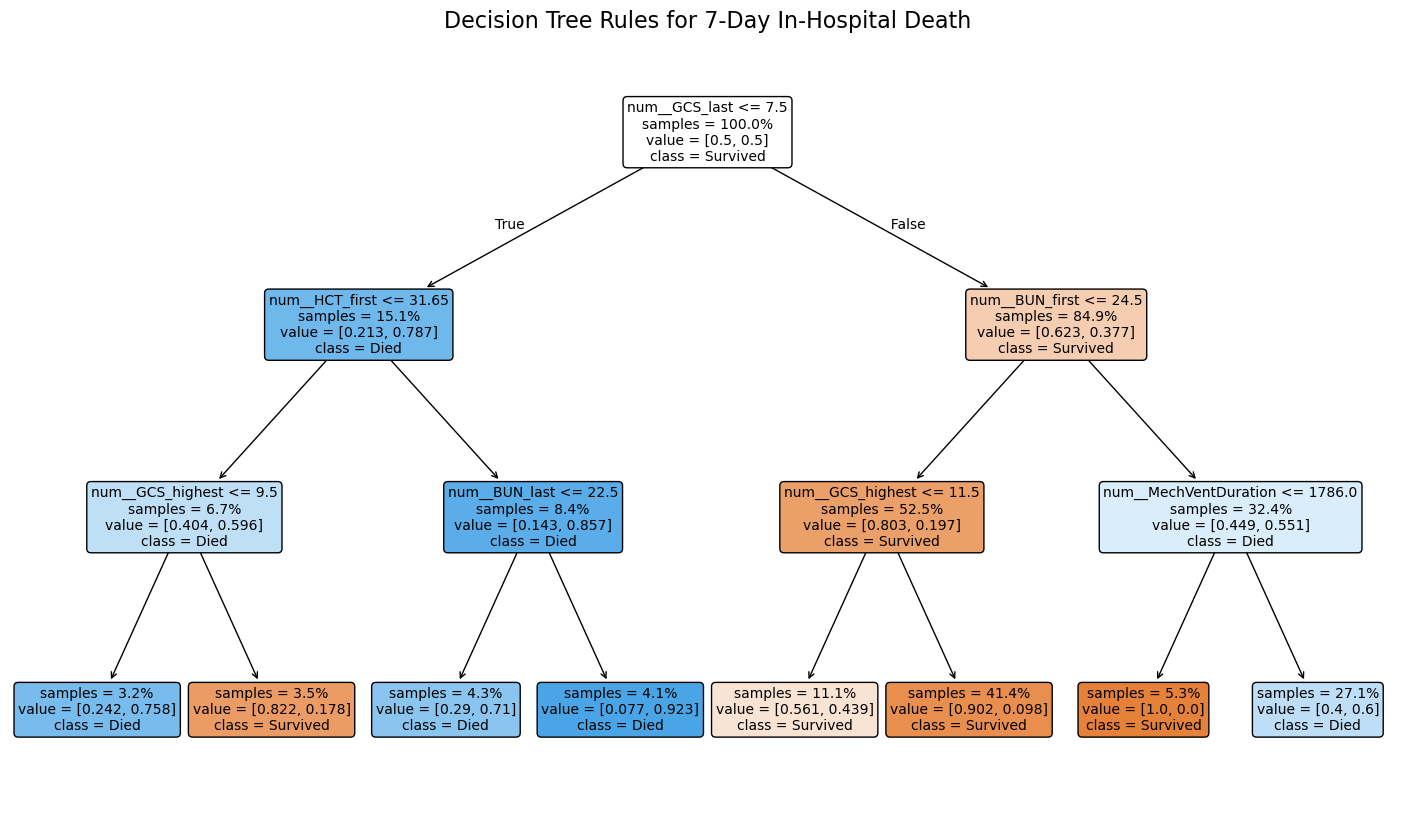

--- Decision Rules as Text ---\n
|--- num__GCS_last <= 7.50
|   |--- num__HCT_first <= 31.65
|   |   |--- num__GCS_highest <= 9.50
|   |   |   |--- class: 1
|   |   |--- num__GCS_highest >  9.50
|   |   |   |--- class: 0
|   |--- num__HCT_first >  31.65
|   |   |--- num__BUN_last <= 22.50
|   |   |   |--- class: 1
|   |   |--- num__BUN_last >  22.50
|   |   |   |--- class: 1
|--- num__GCS_last >  7.50
|   |--- num__BUN_first <= 24.50
|   |   |--- num__GCS_highest <= 11.50
|   |   |   |--- class: 0
|   |   |--- num__GCS_highest >  11.50
|   |   |   |--- class: 0
|   |--- num__BUN_first >  24.50
|   |   |--- num__MechVentDuration <= 1786.00
|   |   |   |--- class: 0
|   |   |--- num__MechVentDuration >  1786.00
|   |   |   |--- class: 1



In [24]:
# --- Step 1: Re-fit a single, clean tree for the 7-day horizon ---
# We use the best settings (hyperparameters) we already found via GridSearchCV.

HORIZON = 7 # Focus on the 7-day model

# Get the best parameters from our previous results
best_params_row = ARTIFACTS["dt_metrics"].query("set == 'val' and horizon_days == @HORIZON").iloc[0]
best_depth = int(best_params_row["best_max_depth"])
best_leaf_samples = int(best_params_row["best_min_samples_leaf"])

print(f"Refitting 7-day tree with max_depth={best_depth} and min_samples_leaf={best_leaf_samples}\\n")

# Get the correct "evaluable" data for this horizon
mask_train = ARTIFACTS["labels_train"][HORIZON]["mask"]
y_train_h = ARTIFACTS["labels_train"][HORIZON]["y_true"][mask_train].to_numpy()

# Use the already preprocessed data
Xt_train_h = Xt_train.loc[mask_train]

# Fit the final Decision Tree model
final_tree = DecisionTreeClassifier(
    random_state=SEED,
    class_weight="balanced", # Helps the model pay attention to the rare "death" event
    max_depth=best_depth,
    min_samples_leaf=best_leaf_samples
)
final_tree.fit(Xt_train_h, y_train_h)

# --- Step 2: Plot the tree to visualize the rules ---
plt.figure(figsize=(18, 10))
plot_tree(
    final_tree,
    feature_names=Xt_train_h.columns.tolist(),
    class_names=["Survived", "Died"], # Label for clarity
    filled=True,       # Color nodes by majority class
    impurity=False,    # Hide Gini impurity for a cleaner look
    proportion=True,   # Show percentage of samples in each class
    rounded=True,      # Use rounded boxes
    fontsize=10
)
plt.title(f"Decision Tree Rules for {HORIZON}-Day In-Hospital Death", fontsize=16)
plt.show()

# --- Step 3: Export the same rules as text ---
# This can be useful for documentation.
rules_text = export_text(final_tree, feature_names=list(Xt_train_h.columns))
print("--- Decision Rules as Text ---\\n")
print(rules_text)

In [26]:
# --- Step 4: Feature Importance (which variables did the tree use?) ---

# The default 'Gini importance' measures how much a feature helps to create "pure" nodes.
feature_importances = pd.DataFrame({
    "feature": Xt_train_h.columns,
    "importance": final_tree.feature_importances_
}).sort_values("importance", ascending=False).head(15)

print("--- Top 15 Features (Gini Importance) ---")
display(feature_importances.style)


# --- Step 5: Auditing the tree's rules (leaves) on the test set ---
# This is the most critical step: do the rules that predict high risk actually
# correspond to groups of patients with high death rates in the unseen test data?

# Get the correct "evaluable" test data for this horizon
mask_test = ARTIFACTS["labels_test"][HORIZON]["mask"]
y_test_h = ARTIFACTS["labels_test"][HORIZON]["y_true"][mask_test].to_numpy()
Xt_test_h = Xt_test.loc[mask_test]

# Find out which leaf each test patient ends up in
leaf_ids_test = final_tree.apply(Xt_test_h)
# Get the predicted probability for each test patient
probabilities_test = final_tree.predict_proba(Xt_test_h)[:, 1]

# Create a summary table
leaf_audit_df = pd.DataFrame({
    "leaf_id": leaf_ids_test,
    "true_outcome": y_test_h,
    "predicted_risk": probabilities_test
})

leaf_summary = (
    leaf_audit_df
    .groupby("leaf_id")
    .agg(
        num_patients=("true_outcome", "size"),
        observed_death_rate=("true_outcome", "mean"),
        avg_predicted_risk=("predicted_risk", "mean")
    )
    .sort_values("avg_predicted_risk", ascending=False)
)

print("\\n--- Leaf Performance Audit on Test Set ---")
display(leaf_summary.style)

--- Top 15 Features (Gini Importance) ---


,feature,importance
21,num__GCS_last,0.407967
68,num__BUN_first,0.253356
43,num__GCS_highest,0.158295
113,num__MechVentDuration,0.109584
74,num__HCT_first,0.046302
92,num__BUN_last,0.024495
6,num__CCU,0.000000
7,num__CSRU,0.000000
4,num__Height,0.000000
5,num__Weight,0.000000


\n--- Leaf Performance Audit on Test Set ---


,num_patients,observed_death_rate,avg_predicted_risk
leaf_id,,,
7,18,0.222222,0.922816
3,21,0.238095,0.757947
6,33,0.151515,0.709917
14,165,0.115152,0.599655
10,61,0.049180,0.439095
4,19,0.052632,0.178232
11,254,0.019685,0.098186
13,25,0.120000,0.000000


Plotting PDP for: ['num__GCS_last', 'num__BUN_first', 'num__GCS_highest']


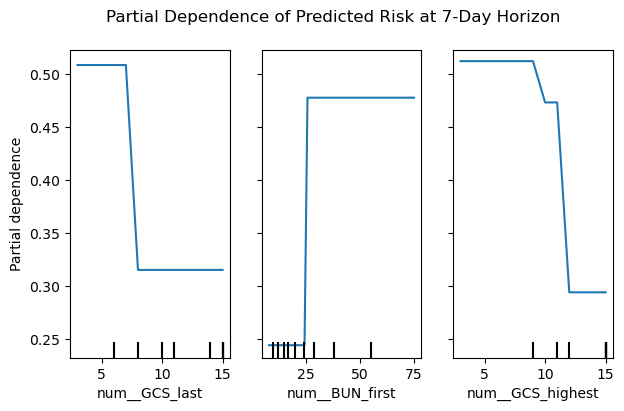

In [34]:
# Partial dependence for features actually used by the tree at 7 days

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import PartialDependenceDisplay

H = 7  # horizon to visualize

# 1) Recreate the evaluable training slice and labels
m_tr = ARTIFACTS["labels_train"][H]["mask"]
Xtr_t = Xt_train.loc[m_tr]
y_tr  = ARTIFACTS["labels_train"][H]["y_true"][m_tr].to_numpy()

# 2) Pull the best hyperparameters we selected for this horizon
best_row  = ARTIFACTS["dt_metrics"].query("set == 'val' and horizon_days == @H").iloc[0]
best_depth = int(best_row["best_max_depth"])
best_leaf  = int(best_row["best_min_samples_leaf"])

# 3) Fit the shallow tree on the same transformed data
dt = DecisionTreeClassifier(
    random_state=SEED,
    class_weight="balanced",
    max_depth=best_depth,
    min_samples_leaf=best_leaf
).fit(Xtr_t, y_tr)

# 4) Pick features the tree actually used (nonzero importance) and prefer continuous ones
imp = pd.Series(dt.feature_importances_, index=Xtr_t.columns)
used = imp[imp > 0].sort_values(ascending=False).index.tolist()

# Heuristic: continuous features created by the preprocessor often start with "num__"
cont_used = [f for f in used if f.startswith("num__")]
targets = cont_used[:3] if len(cont_used) > 0 else used[:3]

if len(targets) == 0:
    print("No features with nonzero importance were found for PDP")
else:
    print("Plotting PDP for:", targets)
    PartialDependenceDisplay.from_estimator(
        dt, Xtr_t, targets, kind="average", grid_resolution=50
    )
    plt.suptitle(f"Partial Dependence of Predicted Risk at {H}-Day Horizon")
    plt.show()


#### **Insights from Partial Dependence Plots**

These plots isolate how the model's risk prediction changes based on a single feature, showing the rules it learned graphically.

* **Plots Show Step-Functions**: Each jump is a specific if-then split the tree learned. The flat lines mean all patients in that range are treated identically by that rule
* **Glasgow Coma Scale (GCS)**: The model learned that lower GCS scores are linked to higher mortality risk. The risk drops sharply once a patient's GCS score is above a certain threshold
* **Blood Urea Nitrogen (BUN)**: An elevated initial BUN measurement acts as a risk threshold. When BUN crosses a specific value, the predicted risk jumps, correctly identifying kidney function's role in patient stability

**Key Takeaways**
* **Clinically Valid Rules**: The tree learns simple, communicable rules that align with clinical intuition (e.g., low consciousness or poor kidney function increases risk)
* **Strengths and Limits**: These plots are excellent for explaining the model's logic for a single variable. However, they show an averaged effect and are not causal. The rules are coarse and may miss more gradual trends

# 6. Random Forest at Fixed Horizons

If a single Decision Tree is like asking one expert for their opinion, a Random Forest is like asking a large, diverse committee of hundreds of experts and taking their majority vote

* **The "Wisdom of the Crowd"**: It's an "ensemble" of many individual Decision Trees. Each tree is trained on a slightly different random sample of the data and is only allowed to consider a random subset of features for each split
* **Reduces Overfitting**: This randomness prevents any single tree from becoming too specialized or "memorizing" the training data. The errors made by one tree are often canceled out by the others, leading to a more stable and accurate model that generalizes better to new patients
* **High Predictive Power**: Random Forests are one of the most powerful "out-of-the-box" classifiers. They often achieve high performance without extensive tuning

**The Trade-Off**
The cost of this increased power is a loss of direct interpretability. We can no longer draw a single flowchart of the rules. However, we can still measure which features were most important to the "committee" as a whole

In [38]:
# Horizons and labels from our central ARTIFACTS store
HORIZONS = ARTIFACTS["horizons_days"]
labels_train = ARTIFACTS["labels_train"]
labels_val   = ARTIFACTS["labels_val"]
labels_test  = ARTIFACTS["labels_test"]

# Use the same frozen preprocessor to prevent data leakage
frozen_pre = FunctionTransformer(lambda X: preprocessor.transform(X))

# --- Define the Pipeline and Search Grid ---
pipe_rf = Pipeline(steps=[
    ("pre", frozen_pre),
    ("clf", RandomForestClassifier(
        random_state=SEED,
        # 'balanced_subsample' adjusts weights for the minority class in each bootstrap sample.
        # This is a robust way to handle the low death rate in our data.
        class_weight="balanced_subsample",
        n_jobs=-1 # Use all available CPU cores for faster training
    ))
])

# A small, practical grid for hyperparameter tuning
param_grid = {
    "clf__n_estimators": [100, 200],      # How many trees in the forest
    "clf__max_depth": [4, 6, 8],          # Max depth of each tree
    "clf__min_samples_leaf": [25, 50]   # Min patients in a final leaf
}

# --- Containers for predictions and metrics ---
rf_pred_train = pd.DataFrame(index=X_train.index)
rf_pred_val   = pd.DataFrame(index=X_val.index)
rf_pred_test  = pd.DataFrame(index=X_test.index)
records = []

print("Training Random Forest for each horizon...")
for h in HORIZONS:
    # Get the correct evaluable cohorts for this horizon
    m_tr = labels_train[h]["mask"]
    m_va = labels_val[h]["mask"]
    m_te = labels_test[h]["mask"]

    y_tr = labels_train[h]["y_true"][m_tr].to_numpy()
    y_va = labels_val[h]["y_true"][m_va].to_numpy()
    y_te = labels_test[h]["y_true"][m_te].to_numpy()

    # Fit GridSearchCV only on the evaluable training data for this horizon
    grid = GridSearchCV(
        estimator=pipe_rf,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=3,
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train.loc[m_tr], y_tr)

    best_params = grid.best_params_
    print(f"Horizon {h}d best params: {best_params}")

    # Get predictions from the best model
    p_tr = grid.predict_proba(X_train)[:, 1]
    p_va = grid.predict_proba(X_val)[:, 1]
    p_te = grid.predict_proba(X_test)[:, 1]

    # Store predictions
    colname = f"RF_Risk_{h}d"
    rf_pred_train[colname] = p_tr
    rf_pred_val[colname]   = p_va
    rf_pred_test[colname]  = p_te

    # Calculate metrics on the identical evaluable cohorts
    def _safe_metrics(y, p):
        if y.size == 0 or len(np.unique(y)) < 2:
            return np.nan, np.nan, np.nan
        return roc_auc_score(y, p), average_precision_score(y, p), brier_score_loss(y, p)

    au_tr, ap_tr, br_tr = _safe_metrics(y_tr, p_tr[m_tr])
    au_va, ap_va, br_va = _safe_metrics(y_va, p_va[m_va])
    au_te, ap_te, br_te = _safe_metrics(y_te, p_te[m_te])

    # Append results for all sets to our records list
    for s, au, ap, br, mask in [
        ("train", au_tr, ap_tr, br_tr, m_tr),
        ("val",   au_va, ap_va, br_va, m_va),
        ("test",  au_te, ap_te, br_te, m_te),
    ]:
        records.append({
            "model": "RandomForest",
            "set": s,
            "horizon_days": h,
            "auroc": float(au),
            "auprc": float(ap),
            "brier": float(br),
            "n_evaluable": int(mask.sum()),
            "best_n_estimators": best_params["clf__n_estimators"],
            "best_max_depth": best_params["clf__max_depth"],
            "best_min_samples_leaf": best_params["clf__min_samples_leaf"]
        })

# --- Create and display the final metrics table ---
rf_metrics = pd.DataFrame.from_records(records).sort_values(["set", "horizon_days"]).reset_index(drop=True)
for c in ["auroc", "auprc", "brier"]:
    rf_metrics[c] = pd.to_numeric(rf_metrics[c], errors="coerce").round(3)

order_sets = pd.CategoricalDtype(["train", "val", "test"], ordered=True)
rf_metrics["set"] = rf_metrics["set"].astype(order_sets)

display(rf_metrics.style)

# --- Store results for our final comparison ---
ARTIFACTS["rf_pred_train"] = rf_pred_train
ARTIFACTS["rf_pred_val"]   = rf_pred_val
ARTIFACTS["rf_pred_test"]  = rf_pred_test
ARTIFACTS["rf_metrics"]    = rf_metrics


Training Random Forest for each horizon...
Horizon 7d best params: {'clf__max_depth': 8, 'clf__min_samples_leaf': 25, 'clf__n_estimators': 100}
Horizon 30d best params: {'clf__max_depth': 6, 'clf__min_samples_leaf': 25, 'clf__n_estimators': 200}
Horizon 60d best params: {'clf__max_depth': 4, 'clf__min_samples_leaf': 25, 'clf__n_estimators': 200}


,model,set,horizon_days,auroc,auprc,brier,n_evaluable,best_n_estimators,best_max_depth,best_min_samples_leaf
0,RandomForest,test,7,0.819000,0.274000,0.110000,596,100,8,25
1,RandomForest,test,30,0.732000,0.808000,0.218000,160,200,6,25
2,RandomForest,test,60,0.772000,0.985000,0.113000,114,200,4,25
3,RandomForest,train,7,0.978000,0.783000,0.088000,1833,100,8,25
4,RandomForest,train,30,0.906000,0.938000,0.189000,488,200,6,25
5,RandomForest,train,60,0.996000,1.000000,0.102000,353,200,4,25
6,RandomForest,val,7,0.841000,0.314000,0.100000,615,100,8,25
7,RandomForest,val,30,0.626000,0.689000,0.235000,168,200,6,25
8,RandomForest,val,60,0.572000,0.929000,0.136000,119,200,4,25


### **Clinical Insights**

* **Highest Predictive Accuracy**
    The Random Forest achieves the best discrimination on the test set, with an **AUROC of 0.82** at the 7-day horizon. This is a clear improvement over both the Cox model (~0.80) and the single Decision Tree (~0.76), making it the most effective model for ranking patients by risk

* **Better Generalization**
    While there is still a gap between training and test scores, the ensemble approach makes the Random Forest more robust than a single tree

* **The Interpretability Trade-Off**
    This boost in accuracy comes at a cost: we can no longer visualize a simple set of if-then rules

## 6.1. Is the Random Forest Clinically Useful?

Our Random Forest model is the most accurate predictor, but accuracy alone isn't enough. We need to verify it works in a way that is trustworthy, fair, and practical for clinical use

* **1. Feature Importance**
    * Ranks the clinical variables the model found most predictive.
    * uilds trust by confirming the model uses clinically sensible factors (e.g., SOFA score) to make decisions.

* **2. Risk Stratification**
    * Checks if patients the model calls "high-risk" actually have a higher death rate in the real data.
    * Verifies that a high predicted risk score from the model corresponds to a genuinely high-risk patient.

* **3. Decision Threshold Analysis**
    * Simulates a clinical alert (e.g., "flag patients with >20% risk") to see the trade-off between correct alerts and false alarms.
    * Helps determine a practical action threshold for using the model without causing "alert fatigue" for clinicians

* **4. Subgroup Fairness Check**
    * Tests if the model is equally accurate for different patient groups (e.g., across ICU types).
    * An ethical check to ensure the model is fair and doesn't have a hidden bias against a specific patient population.

* **5. Decision Curve Analysis (DCA)**
    * A plot to weigh the benefits of the model's predictions against the harm of unnecessary interventions.
    * Answers the critical question: "Is using this model better than simply treating all patients, or treating none?" It helps quantify the model's real-world value.



### **Analysis 1: Feature Importance**

This is our first step in "opening the black box". We will ask the Random Forest which clinical variables it found most useful for making its predictions. We use two methods to ensure our results are reliable.

* **What this does**:
    * **Impurity Importance**: Ranks features by how much they help create "pure" groups of patients (i.e., groups that are all survivors or all deaths). It's fast but can sometimes be biased.
    * **Permutation Importance**: Ranks features by shuffling their values and measuring how much this shuffle hurts the model's performance. It is more computationally intensive but often more reliable.
* **What to look for**:
    * We want to see clinically sensible variables (like SOFA, GCS, BUN) at the top of both lists.
    * Strong agreement between the two methods gives us confidence that the model has identified stable, meaningful patterns.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, precision_recall_fscore_support, confusion_matrix

H = 7  # change to 30 or 60 to repeat

# Evaluable masks and labels
m_tr = ARTIFACTS["labels_train"][H]["mask"]
m_va = ARTIFACTS["labels_val"][H]["mask"]
m_te = ARTIFACTS["labels_test"][H]["mask"]

y_tr = ARTIFACTS["labels_train"][H]["y_true"][m_tr].to_numpy()
y_va = ARTIFACTS["labels_val"][H]["y_true"][m_va].to_numpy()
y_te = ARTIFACTS["labels_test"][H]["y_true"][m_te].to_numpy()

# Use transformed design matrices so feature names are available
Xtr_t = Xt_train.loc[m_tr]
Xva_t = Xt_val.loc[m_va]
Xte_t = Xt_test.loc[m_te]

# Best hyperparameters from validation table
row = ARTIFACTS["rf_metrics"].query("set == 'val' and horizon_days == @H").iloc[0]
best_n  = int(row["best_n_estimators"])
best_d  = int(row["best_max_depth"])
best_lf = int(row["best_min_samples_leaf"])

rf = RandomForestClassifier(
    n_estimators=best_n,
    max_depth=best_d,
    min_samples_leaf=best_lf,
    class_weight="balanced_subsample",
    random_state=SEED,
    n_jobs=-1
)
rf.fit(Xtr_t, y_tr)

# Impurity importance
imp_df = pd.DataFrame({
    "feature": Xtr_t.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False).head(20).reset_index(drop=True)
imp_df["importance"] = imp_df["importance"].round(3)
display(imp_df)

# Permutation importance on validation
perm = permutation_importance(
    rf, Xva_t, y_va,
    n_repeats=10,
    random_state=SEED,
    scoring="roc_auc",
    n_jobs=-1
)
perm_df = pd.DataFrame({
    "feature": Xva_t.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False).head(20).reset_index(drop=True)
perm_df["importance_mean"] = perm_df["importance_mean"].round(3)
perm_df["importance_std"]  = perm_df["importance_std"].round(3)
display(perm_df)

### **Analysis 2: Risk Stratification on the Test Set**

This is a powerful calibration check. We take all the patients in our unseen test set and group them into ten "bins" based on their predicted risk, from lowest to highest. Then, we calculate the actual death rate for each bin.

* **What this does**: Reports the average predicted risk and the actual (observed) death rate for each patient bin.
* **What to look for**: A clear "staircase" pattern. The bin with the highest predicted risk should also have the highest observed death rate. This confirms that when the model predicts a high risk, it corresponds to a real-world high risk, making the model's scores trustworthy.

In [ ]:
# Predicted probabilities on the test evaluable cohort
p_te = rf.predict_proba(Xte_t)[:, 1]

# Deciles of risk with observed event rates
q = pd.qcut(p_te, q=10, labels=False, duplicates="drop")
dec = pd.DataFrame({"decile": q, "y": y_te, "p": p_te})
dec_summ = dec.groupby("decile", as_index=False).agg(
    n=("y", "size"),
    risk_mean=("p", "mean"),
    event_rate=("y", "mean")
).sort_values("decile", ascending=False)
dec_summ["risk_mean"] = dec_summ["risk_mean"].round(3)
dec_summ["event_rate"] = dec_summ["event_rate"].round(3)
display(dec_summ)

### **Analysis 3: Finding a Practical Decision Threshold**

A risk score is useful, but a clinical decision is often binary (e.g., "start intervention" or "continue monitoring"). To use our model in practice, we need to choose a risk **threshold** to turn the probability score into an action.

* **What this does**: We'll test a range of thresholds and choose one that achieves a good balance. A common clinical goal is to catch most of the high-risk patients (**high sensitivity/recall**) without flagging too many low-risk patients by mistake (**avoiding false positives**). We will then create a **confusion matrix** to see the concrete numbers of correct and incorrect predictions at that chosen threshold.
* **What to look for**: Whether the chosen threshold delivers acceptable sensitivity for clinicians, and whether the number of false positives (false alarms) is manageable.

In [ ]:
from sklearn.metrics import precision_score, recall_score

# Two simple thresholding strategies at 7 days
# A) Sensitivity target 0.80 if achievable
# B) Maximize F1 if sensitivity target is not achievable
thresholds = np.linspace(0.05, 0.5, 10)
target_sens = 0.80

chosen = None
for t in thresholds:
    yhat = (p_te >= t).astype(int)
    sens = recall_score(y_te, yhat, zero_division=0)
    if sens >= target_sens:
        chosen = ("sens_0.80", t)
        break

if chosen is None:
    # fallback to F1
    f1s = []
    for t in thresholds:
        yhat = (p_te >= t).astype(int)
        prec = precision_score(y_te, yhat, zero_division=0)
        rec = recall_score(y_te, yhat, zero_division=0)
        f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0
        f1s.append((t, f1))
    t = max(f1s, key=lambda z: z[1])[0]
    chosen = ("f1_max", t)

strategy, tstar = chosen
yhat = (p_te >= tstar).astype(int)

tn, fp, fn, tp = confusion_matrix(y_te, yhat).ravel()
prec = precision_score(y_te, yhat, zero_division=0)
rec  = recall_score(y_te, yhat, zero_division=0)
spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
brier = brier_score_loss(y_te, p_te)

summary = pd.DataFrame([{
    "horizon_days": H,
    "strategy": strategy,
    "threshold": round(float(tstar), 3),
    "precision": round(float(prec), 3),
    "recall_sensitivity": round(float(rec), 3),
    "specificity": round(float(spec), 3),
    "brier": round(float(brier), 3),
    "tp": int(tp), "fp": int(fp), "fn": int(fn), "tn": int(tn),
    "n_evaluable": int(len(y_te))
}])
display(summary)

### **Analysis 4: Decision Curve Analysis (DCA)**

This is a more advanced analysis that measures the "net benefit" of using the model to make decisions compared to simpler default strategies.

* **What this does**: It plots the net benefit of using the model across a range of risk thresholds against two defaults: "treat all patients" and "treat no patients".
* **What to look for**: The model adds clinical value in regions where its curve is above both the "treat all" and "treat none" lines. The peak of the curve suggests an optimal threshold range for clinical action.

In [ ]:
# Net benefit vs threshold compared with treat-none and treat-all on the same test evaluable cohort
# Net benefit = (TP/N) - (FP/N) * (pt / (1 - pt))

def net_benefit(y, p, thresholds):
    nb = []
    N = len(y)
    for t in thresholds:
        if t >= 1.0: continue # Avoid division by zero
        yhat = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, yhat).ravel()
        pt = t
        nb_model = (tp / N) - (fp / N) * (pt / (1 - pt))
        nb_all   = (y.sum() / N) - ((N - y.sum()) / N) * (pt / (1 - pt))
        nb_none  = 0.0
        nb.append({"threshold": t, "nb_model": nb_model, "nb_all": nb_all, "nb_none": nb_none})
    return pd.DataFrame(nb)

ths = np.linspace(0.05, 0.5, 10)
nb_df = net_benefit(y_te, p_te, ths)
nb_df["threshold"] = nb_df["threshold"].round(2)
nb_df["nb_model"]  = nb_df["nb_model"].round(3)
nb_df["nb_all"]    = nb_df["nb_all"].round(3)
display(nb_df)

plt.figure(figsize=(6,4))
plt.plot(nb_df["threshold"], nb_df["nb_model"], marker="o", label="RandomForest")
plt.plot(nb_df["threshold"], nb_df["nb_all"], linestyle="--", label="Treat all")
plt.axhline(0, color="gray", linestyle="--", label="Treat none")
plt.xlabel("Threshold probability")
plt.ylabel("Net benefit")
plt.title(f"Decision curve at {H} days")
plt.legend()
plt.tight_layout()
plt.show()

--- Subgroup Performance Checks at 7 Days (Test Set) ---


,Group,Level,Num_Patients,AUROC
0,Gender,0.000000,244,0.692603
1,Gender,1.000000,352,0.714532
2,CCU,0.000000,520,0.683789
3,CCU,1.000000,76,0.746324
4,CSRU,0.000000,484,0.687048
5,CSRU,1.000000,112,0.509091
6,SICU,0.000000,411,0.663465
7,SICU,1.000000,185,0.748950


### **Analysis 5: Subgroup Fairness Check**

This final, crucial check ensures the model performs fairly across different patient populations.

* **What this does**: Calculates the model's performance (AUROC) separately for key demographic and clinical subgroups (e.g., Gender, ICU Type).
* **What to look for**: The AUROC should be reasonably stable across all subgroups. A large performance drop for a specific group is a red flag for bias and warrants further investigation before the model could ever be deployed.

In [ ]:
# Subgroup checks for Sex and ICU type on evaluable test cohort
# Adjust column names if your dataset uses different ones

def subgroup_metric(colname):
    out = []
    for level, idx in X_test.loc[m_te].groupby(colname).groups.items():
        y_sub = y_te[X_test.loc[m_te].index.isin(idx)]
        p_sub = p_te[X_test.loc[m_te].index.isin(idx)]
        if len(np.unique(y_sub)) < 2:
            au = np.nan
        else:
            au = roc_auc_score(y_sub, p_sub)
        out.append({"group": colname, "level": level, "n": int(len(y_sub)), "auroc": np.round(au, 3)})
    return pd.DataFrame(out)

subs = []
for col in ["Gender", "ICUtype", "CCU", "CSRU", "SICU"]:
    if col in X_test.columns:
        subs.append(subgroup_metric(col))

if len(subs):
    sub_tbl = pd.concat(subs, ignore_index=True)
    display(sub_tbl)
else:
    print("No subgroup columns found among the requested candidates")